In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams, conv #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [6]:
qb = 1 # qubit to operate on

# Conversion factors from standard SI units
us = 1e6
ns = 1e9
GHz = 1e-9

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 1 has a 
  - T1 time of 75.63104275299565 microseconds
  - T2 time of 84.21924543326948 microseconds
  - U2 gate error of 0.0002498990608237925
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.767709392343865 GHz


In [7]:
shots = 1024 # determines clarity of results

period = 1000 # Rabi oscillation period
cycles = [5, 20, 40, 80, 120, 160] # number of rabi cycles to perform for each oscillation
datapoints_per_period = 50 # density of datapoints in a cycle capture
cycles_to_plot = 7 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const = 23.66156363955276 #54.07447683508908
predict_power =  -0.9940037912357684 #-0.9924372112785861

sig_predict_const = 5.35893609525708 #11.48089749887833 
sig_predict_power = -0.96547411076104 #-0.9672752940591574 

In [8]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = period // 64 # density of datapoints in a cycle capture
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        64)
    
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = get_closest_multiple_of_16(drive_times[i] - (6 * drive_sigma))

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
                    
        # add end cap
        this_schedule += Play(end_cap, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

In [97]:
len(experiments)

332

In [98]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [9]:
job = backend.retrieve_job('5f04884d7b75a90012497674')

In [10]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [11]:
qb_rabi_data = []
all_params = []
all_fits = []
all_convs = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p, c = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 5])
    all_params.append(p)
    all_convs.append(c)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    
    single_period_data = np.array(single_period_data)
    # residual sum of squares
    ss_res = np.sum((single_period_data - np.array(y_fit)) ** 2)
    # total sum of squares
    ss_tot = np.sum((single_period_data - np.mean(single_period_data)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    
    all_fits.append(y_fit)

0.9976738677454345
0.8063762147143807
0.5731809856117619
0.43989407218138
0.44522721728714587
0.5046971247958094


Period: 1094.0983450541619 dt


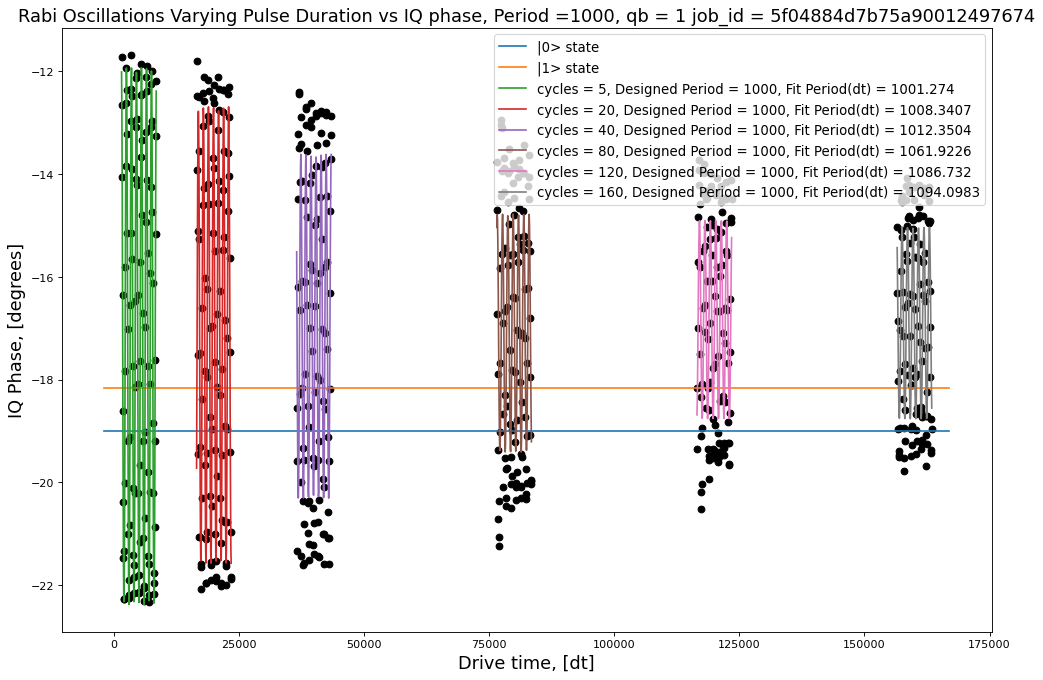

In [12]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

start_plot_time = (period*cycles[0])-(len(data_times[0]) * 64)
end_plot_time = (period*cycles[-1])+(len(data_times[-1]) * 64)
plt.plot([start_plot_time, end_plot_time],2*[state0],label="|0> state")
plt.plot([start_plot_time, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
print(f'Period: {p[2]} dt')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb) + " job_id = " + str(job.job_id()), fontsize=16)
plt.show()

In [102]:
sigma = []
for i in all_convs:
    print(i)
    perr = np.sqrt(np.diag(i))
    print(perr)
    sigma.append(perr[0])
    print()

[[ 8.13493531e-04  2.07696960e-06  1.81686965e-04 -1.08045083e-05]
 [ 2.07696960e-06  4.00910063e-04  6.37730521e-05 -6.03790117e-06]
 [ 1.81686965e-04  6.37730521e-05  3.79452564e-02 -2.39470038e-03]
 [-1.08045083e-05 -6.03790117e-06 -2.39470038e-03  1.77437152e-04]]
[0.02852181 0.02002274 0.19479542 0.01332055]

[[ 1.04612462e-03  1.01069422e-05  2.00795232e-04 -4.93931136e-05]
 [ 1.01069422e-05  5.33078411e-04 -5.72885401e-04  1.45111390e-04]
 [ 2.00795232e-04 -5.72885401e-04  6.03593235e-02 -1.53857486e-02]
 [-4.93931136e-05  1.45111390e-04 -1.53857486e-02  3.96098654e-03]]
[0.03234385 0.02308849 0.24568135 0.06293637]

[[ 8.47363996e-04  8.04704337e-06  2.09031391e-04 -1.07514539e-04]
 [ 8.04704337e-06  4.32541183e-04 -5.29525931e-04  2.69765926e-04]
 [ 2.09031391e-04 -5.29525931e-04  5.94747107e-02 -3.02280528e-02]
 [-1.07514539e-04  2.69765926e-04 -3.02280528e-02  1.54018053e-02]]
[0.02910952 0.02079762 0.24387437 0.12410401]

[[ 1.36559326e-03 -1.52681540e-06 -4.84276621e-04  4

In [103]:
for i in range(len(cycles)):
    print(f'{abs(np.array(all_params)[:,0][i])}')
print()
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')
print()
print(sigma)

5.481859622026316
5.218050729357216
4.746477719110408
3.6774717690109506
2.579301173831886
1.7242753601650007

10.991682033693614
10.638148615978153
9.736813562294337
7.476588832738884
5.309522639911975
4.00881906218487

[0.028521807983456028, 0.03234384977473141, 0.029109517282003564, 0.03695393427008624, 0.03611035501467706, 0.03949123334050929]


0.9979800762243748


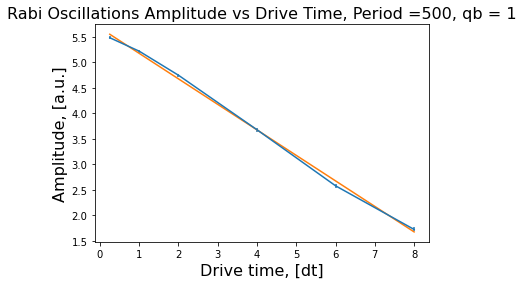

In [105]:
xvals = [(period*i)/10000 for i in cycles]
amps = abs(np.array(all_params)[:,0])
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, conv = curve_fit(func, xvals, amps, [4, 0.1, 1], sigma, maxfev=3000)
y_fit = [func(x, p[0], p[1], p[2]) for x in xvals]

amps = np.array(amps)
# residual sum of squares
ss_res = np.sum((amps - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((amps - np.mean(amps)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(xvals, amps, yerr=sigma)
plt.plot(xvals, y_fit)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Rabi Oscillations Amplitude vs Drive Time, Period =" + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [106]:
print(p)
print(f'{p[1]}')
print(f'{drive_amp}')
print(conv)

[ 7.19305637e+03  6.95179019e-05 -7.18738118e+03]
6.951790189110869e-05
0.04646018939615311
[[ 4.05024510e+12 -3.91548957e+04 -4.05024521e+12]
 [-3.91548957e+04  3.78521753e-04  3.91548968e+04]
 [-4.05024521e+12  3.91548968e+04  4.05024531e+12]]


0.9834770334993006


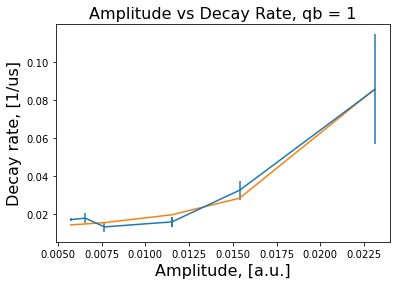

[ 8.47281364e-04 -1.93259367e+02  1.19193248e-02]
[[ 9.92796938e-07  4.86011954e-02 -3.99628045e-06]
 [ 4.86011954e-02  2.38646262e+03 -1.93342428e-01]
 [-3.99628045e-06 -1.93342428e-01  1.92119668e-05]]


In [114]:
more_conv = [
[[ 0.23720507, -0.01276633, -0.26286516],
 [-0.01276633,  0.00083369,  0.0155273 ],
 [-0.26286516,  0.0155273 ,  0.30719439]],
[[ 7.48194372e-02, -1.29877271e-03, -7.96111015e-02],
 [-1.29877271e-03,  2.42897360e-05,  1.41591247e-03],
 [-7.96111015e-02,  1.41591247e-03,  8.56118430e-02]],
[[ 7.20085591e-02, -6.72038371e-04, -7.52674547e-02],
 [-6.72038371e-04,  6.55805652e-06,  7.10905198e-04],
 [-7.52674547e-02,  7.10905198e-04,  7.90460810e-02]],
[[ 7.20085591e-02, -6.72038371e-04, -7.52674547e-02],
 [-6.72038371e-04,  6.55805652e-06,  7.10905198e-04],
 [-7.52674547e-02,  7.10905198e-04,  7.90460810e-02]],
[[ 5.37815807e-02, -5.81925585e-04, -5.87683365e-02],
 [-5.81925585e-04,  6.97983566e-06,  6.62940314e-04],
 [-5.87683365e-02,  6.62940314e-04,  6.56593762e-02]],
[[ 1.82736505e-02, -2.68358241e-04, -1.95193759e-02],
 [-2.68358241e-04,  6.02793454e-06,  3.68254061e-04],
 [-1.95193759e-02,  3.68254061e-04,  2.45831759e-02]],
[[ 8.56963032e-04, -1.20548690e-05, -8.82773596e-04],
 [-1.20548690e-05,  3.61181748e-07,  2.02097766e-05],
 [-8.82773596e-04,  2.02097766e-05,  1.26531099e-03]]
]
more_sigma = [np.sqrt(np.diag(i))[1] for i in more_conv]

gammas_tilde = [0.098961095, 0.045881203, 0.029255538, 0.029255538, 0.026616036, 0.031222099, 0.030430938]
gammas = [g - 1/(props.t1(qb) * us) for g in gammas_tilde]
amplitudes = [0.023133165, 0.015384435, 0.01151832, 0.01151832, 0.00766012, 0.006559715, 0.005735129]

def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, pcov = curve_fit(func, amplitudes, gammas, [0.1, -0.1, 0])
y_fit = [func(x, p[0], p[1], p[2]) for x in amplitudes]

gammas = np.array(gammas)
# residual sum of squares
ss_res = np.sum((gammas - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((gammas - np.mean(gammas)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(amplitudes, gammas, yerr=more_sigma)
plt.plot(amplitudes, y_fit)
plt.ylabel('Decay rate, [1/us]', fontsize=16)
plt.xlabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Amplitude vs Decay Rate, qb = " + str(qb), fontsize=16)
plt.show()
print(p)
print(pcov)
# print(p[0])
# print(p[1])
# print(pcov[0,0]**0.5)
# print(pcov[1,1]**0.5)

[  -1.92998894  -16.83087944 1086.73200166  -55.39271595]


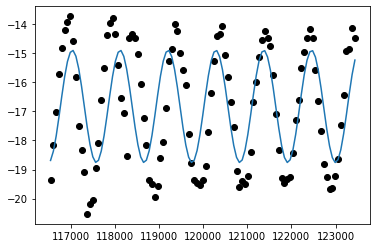

In [13]:
i = 4
plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
plt.plot(data_times[i], all_fits[i])
print(all_params[i])